In [1]:
!pip3 install -Uqq fastai

     |████████████████████████████████| 204kB 26.1MB/s 
     |████████████████████████████████| 61kB 8.4MB/s 


In [2]:
!pip install -Uqq fastbook

     |████████████████████████████████| 727kB 27.3MB/s 
     |████████████████████████████████| 51kB 7.5MB/s 
     |████████████████████████████████| 1.2MB 46.5MB/s 
     |████████████████████████████████| 61kB 9.2MB/s 


In [4]:
import fastbook
fastbook.setup_book()

Mounted at /content/gdrive


In [5]:
import pathlib
from fastai.vision.all import *
from fastai.data.all import *

In [7]:
# the path to the images:
chrono_images_path = pathlib.Path("/content/gdrive/MyDrive/images")

In [36]:
# creating the DataBlock
data = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(seed=42),
    item_tfms=[Resize(size=210)],
    batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)]    
)

In [37]:
# looking at the data summary:
data.summary(chrono_images_path)

Setting-up type transforms pipelines
Found 3926 items
2 datasets of sizes 3141,785
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /content/gdrive/MyDrive/images/jaegerlecoultre/jaegerlecoultre-6-173500.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=210x210
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /content/gdrive/MyDrive/images/jaegerlecoultre/jaegerlecoultre-6-173500.jpg
    applying parent_label gives
      jaegerlecoultre
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(5)

Final sample: (PILImage mode=RGB size=210x210, TensorCategory(5))


Found 3926 items
2 datasets of sizes 3141,785
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None,

In [38]:
# Creating the DataLoader
batch_size = 64
dls = data.dataloaders(chrono_images_path, bs=batch_size)

In [39]:
# length of the training and validation datasets:
dls.train.n, dls.valid.n

(3141, 785)

In [40]:
# The Classes in the Images:
dls.vocab

['audemarspiguet', 'breitling', 'cartier', 'gucci', 'iwc', 'jaegerlecoultre', 'movado', 'omega', 'panerai', 'patekphilippe', 'rolex', 'seiko', 'zenith']

In [41]:
# getting the first batch of train and valid sets:
valid_batch_one = dls.valid.one_batch()
train_batch_one = dls.train.one_batch()

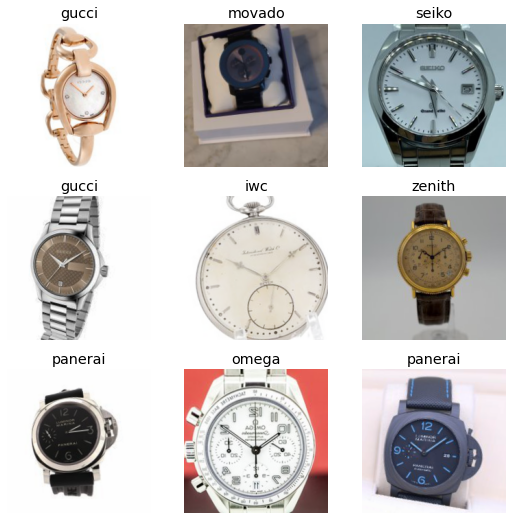

In [42]:
# Looking at the Training batch:
dls.train.show_batch(b=train_batch_one)

In [43]:
# Creating the Learner:

learner = cnn_learner(dls=dls, arch=resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [44]:
# summary of the model:
learner.summary()

Sequential (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 105 x 105 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                      

In [45]:
# training the model for 5 epochs:
learner.fit_one_cycle(n_epoch=5)

epoch,train_loss,valid_loss,error_rate,time
0,3.280965,1.837416,0.573248,08:43
1,2.378026,1.496311,0.458599,00:22
2,1.871519,1.370556,0.433121,00:22
3,1.533219,1.317108,0.408917,00:21
4,1.362245,1.300745,0.406369,00:21


In [46]:
# looking at the model interpretation:
interpret = ClassificationInterpretation.from_learner(learner)

In [54]:
# classification report:
interpret.print_classification_report()

                 precision    recall  f1-score   support

 audemarspiguet       0.76      0.86      0.81        51
      breitling       0.57      0.63      0.60        46
        cartier       0.70      0.68      0.69        73
          gucci       0.77      0.56      0.65        59
            iwc       0.60      0.61      0.60        64
jaegerlecoultre       0.49      0.51      0.50        74
         movado       0.67      0.43      0.52        68
          omega       0.38      0.46      0.42        46
        panerai       0.77      0.92      0.84        63
  patekphilippe       0.40      0.43      0.41        67
          rolex       0.79      0.76      0.77        54
          seiko       0.46      0.48      0.47        65
         zenith       0.45      0.44      0.44        55

       accuracy                           0.59       785
      macro avg       0.60      0.60      0.59       785
   weighted avg       0.60      0.59      0.59       785



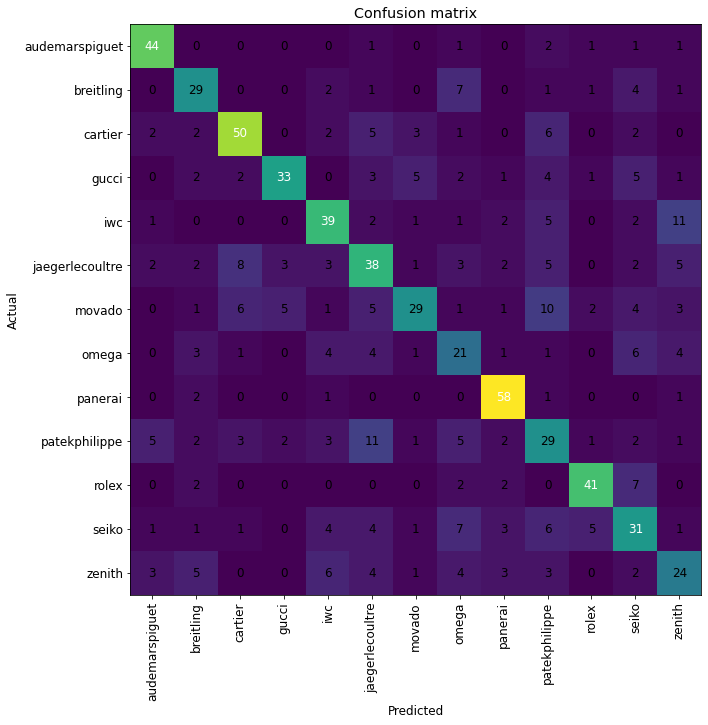

In [48]:
# looking at the confusion matrix:
interpret.plot_confusion_matrix(cmap='viridis', figsize=(10,10))

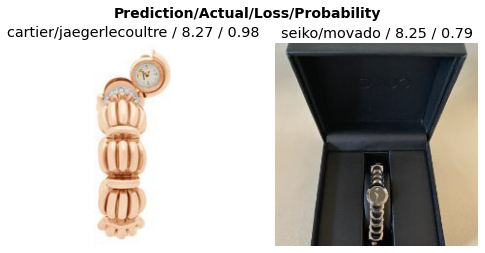

In [53]:
# plotting the top losses:
interpret.plot_top_losses(2, figsize=(8,4))

In [55]:
# Saving the model that we have trained as of now:
learner.save('chronoanalyzer_model_stage-1')

Path('models/chronoanalyzer_model_stage-1.pth')

SuggestedLRs(lr_min=1.0964782268274575e-05, lr_steep=5.754399353463668e-06)

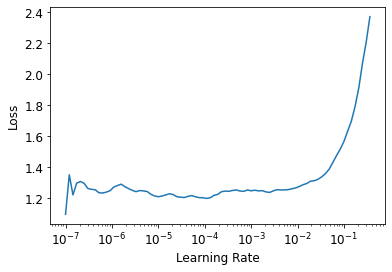

In [56]:
# optimizing/fine-tuning the model:

learner.lr_find()

In [57]:
# un-freezing the earlier layers to train them:
learner.unfreeze()

In [58]:
# training the model again:
learner.fit_one_cycle(n_epoch=6, lr_max=slice(1e-4, 1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,1.586613,2.646214,0.555414,00:27
1,1.521316,1.884388,0.452229,00:27
2,1.243710,1.290198,0.370701,00:27
3,0.905628,0.990697,0.282803,00:27
4,0.570212,0.747573,0.212739,00:27
5,0.347508,0.751388,0.211465,00:27


In [59]:
# saving the model at stage 2:
learner.save('chronoanalyzer_model_stage-2')

Path('models/chronoanalyzer_model_stage-2.pth')

In [60]:
# exporting the model, instead of the weights:
learner.export('classifier_stage1.pkl')